### 1. 理论知识

1. 线性回归：y=ax+b，逻辑回归：y=sigmoid(ax+b)，即**y = 1/(1+e^(-(ax+b)))**，添加xn+1列=1，则有**f(x) = 1/(1+e^(-(X·A)))**

2. sigmoid函数中，随着X的变化，y是一条曲线，值为0~1（可以看作概率），那么，**可以约定yi大于0.5为1，小于0.5为0**，就解决了连续值分类的问题

3. 二分类问题中，y=0或者1的概率：假如袋子里有10个球，7个黑球，3个白球，有放回的摸球，则摸到黑球的概率为p1 = 0.7，摸到白球的概率为1-p1 = 0.3。

4. 则摸到黑球|白球的概率公式可定义为，P(y) = p1^y * (1-p1)^(1-y)，可推出，P(y=1时(摸到黑球)) = p1，P(y=0时(摸到白球)) = 1-p1，

5. 将摸到黑球的概率代入，则得到函数的预测概率：**P(y|x,A) = (1/(1+e^(-(X·A))))^y * (1-1/(1+e^(-(X·A))))^(1-y)**

6. ![Example Image](img/最大似然估计1.jpg)

7. ![Example Image](img/最大似然估计2.jpg)

8. **具体推导见链接**：https://zhuanlan.zhihu.com/p/139122386

9. 最大似然估计与最小二乘法：https://zhuanlan.zhihu.com/p/55793850

d:\ProgramData\miniconda3\envs\ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


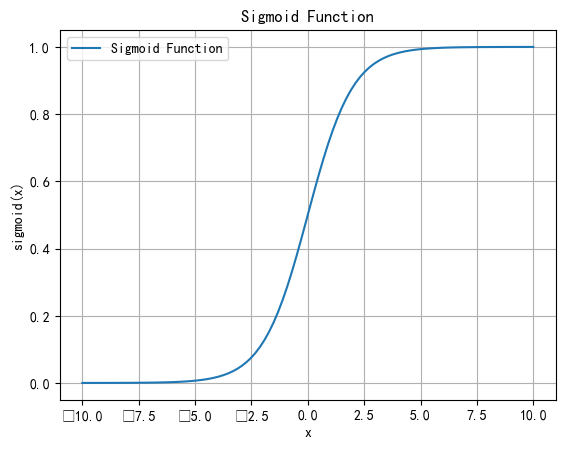

In [422]:
# 绘制sigmoid函数图
from plot_show import plot_sigmoid
plot_sigmoid()

### 2.数据准备

##### 2.1 导入数据集

In [423]:
# 导入模块
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np

# 处理数据集
iris=load_iris()
X = pd.DataFrame(data=iris.data, columns=iris.feature_names)
y = pd.DataFrame(data=iris.target, columns=["label"])

# 特征重命名
map_={
    'sepal length (cm)': '花萼长度',
    'sepal width (cm)': '花萼宽度',
    'petal length (cm)': '花瓣长度',
    'petal width (cm)': '花瓣宽度'
}
X=X.rename(columns=map_)
X

,花萼长度,花萼宽度,花瓣长度,花瓣宽度
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


#### 2.2 数据处理

1. 逻辑回归基于线性回归y=ax+b，y = 1/(1+e^(-(ax+b)))，**添加xn+1列=1**，以融合b到参数A，有**f(x) = 1/(1+e^(-(X·A)))**

**注意！！一定要对数据进行归一化，统一量纲，不然梯度下降大概率无法收敛！！**

In [424]:
from sklearn.preprocessing import Normalizer

# 数据归一化！！！！非常重要！！！！
X_1=Normalizer().fit_transform(X)

# 添加补充列
X_1=np.hstack((X_1,np.ones((len(X_1),1))))

# 最后将y array化，方便后续计算，矩阵乘法@符号，和A.dot(B)形式都要求为array，否则只能用np.dot(A,B)
y=y.values
X_1

array([[0.80377277, 0.55160877, 0.22064351, 0.0315205 , 1.        ],
       [0.82813287, 0.50702013, 0.23660939, 0.03380134, 1.        ],
       [0.80533308, 0.54831188, 0.2227517 , 0.03426949, 1.        ],
       [0.80003025, 0.53915082, 0.26087943, 0.03478392, 1.        ],
       [0.790965  , 0.5694948 , 0.2214702 , 0.0316386 , 1.        ],
       [0.78417499, 0.5663486 , 0.2468699 , 0.05808704, 1.        ],
       [0.78010936, 0.57660257, 0.23742459, 0.0508767 , 1.        ],
       [0.80218492, 0.54548574, 0.24065548, 0.0320874 , 1.        ],
       [0.80642366, 0.5315065 , 0.25658935, 0.03665562, 1.        ],
       [0.81803119, 0.51752994, 0.25041771, 0.01669451, 1.        ],
       [0.80373519, 0.55070744, 0.22325977, 0.02976797, 1.        ],
       [0.786991  , 0.55745196, 0.26233033, 0.03279129, 1.        ],
       [0.82307218, 0.51442011, 0.24006272, 0.01714734, 1.        ],
       [0.8025126 , 0.55989251, 0.20529392, 0.01866308, 1.        ],
       [0.81120865, 0.55945424, 0.

### 3. 算法实现

#### 3.1 梯度下降
**非凸函数，不可正规方程求解**

逻辑回归最大化似然估计函数，即最小化负的似然估计函数。

1. ![Example Image](img/最大似然估计3.jpg)

2. ![Example Image](img/最大似然估计4.jpg)



In [425]:
# 定义梯度下降函数：主要是更新梯度，求解系数A

def solver(y):

    # 设置迭代次数与下降速率
    n_iterations = 100000
    learning_rate = 0.01

    # 设置随机初始 A
    A = np.random.rand(X_1.shape[1], 1)
    n = X_1.shape[0]

    for _ in range(n_iterations):

        # 梯度求解：核心公式！！！！！
        y_pre = 1/(1+np.exp(-np.dot(X_1, A)))
        gradient = np.dot(X_1.T, (y_pre - y)) / n
        
        # 参数迭代
        A = A - learning_rate * gradient
    
    y_pre = 1/(1+np.exp(-np.dot(X_1, A)))
    return y_pre



In [426]:
# 鸢尾花是三分类，需要将其转换为二分类，即构造三个分类器，分别计算标签为[0,1,2]的概率。
label_count = len(np.unique(y))
if label_count==2:
    pass
else:
    result={}
    for i in np.unique(y):

        # 为每个分类器当前标签分配1，其他标签分配0，构造新标签label
        label=np.zeros_like(y)
        label[y==i]=1

        # 梯度下降求解
        y_pre=solver(label).flatten().tolist()

        # 添加结果
        result[i]=y_pre

In [427]:
# 将三分类的结果转化成dataframe
result_pd=pd.DataFrame(data=result)

# 找到每一行中具有最大值的列名，就是预测的标签
y_pre = result_pd.idxmax(axis=1)

In [428]:
# 校验准确率
from sklearn.metrics import accuracy_score

# 计算AUC值
accuracy_score = accuracy_score(y, y_pre)

# 输出计算得到的AUC值
print("分类准确率:", accuracy_score)

分类准确率: 0.96


### 4. 总结

1. 正规方程：**J(A) = 0 = X.T·X·A - X.T·Y**

2. 梯度：**ΔA = gradient = (1/n)·X.T·(X·A - Y)**

3. 由于 **最小二乘法** 与 **梯度下降** 的损失函数一致：**J(A) = (1/2n) · ( X·A − Y )^2**

4. 所以对最小二乘法求导=0得到的正规方程 = 梯度*n

5. 尚未掌握：**损失函数求导**、**正规方程求解**、**损失函数求解梯度**，等数学推导
